# CNN inference with NVIDIA GPU

We have the basics of Neural Networks optimisation figured out! We can start working with the actual hardware platforms!

We'll start with neural networks inference on NVIDIA GPU devices. We'll get famialir with NVIDIA `TensorRT` framework, test it with host GPU (or Colab GPU) and than test the NVIDIA Jetson Nano embeddedGPU devices.

You can find out more here: https://www.nvidia.com/pl-pl/autonomous-machines/embedded-systems/jetson-nano-developer-kit/.

Today, we'll use `TensorFlow` for our Neural Networks. We aware however, that `TensorRT` is compatible with other frameworks as well (including PyTorch).

You can find out more here: https://developer.nvidia.com/tensorrt.

First, install and import necessary libraries.

**Attention!** If you use Google Colab use following code. However, if you work with PC - you'll need to set up docker image first (below).

In [ ]:
# For Google Colab
!pip3 install tensorflow[and-cuda]==2.14.*

In [ ]:
# For host PC (run in terminal)
docker pull nvcr.io/nvidia/tensorflow:22.01-tf2-py3
# Create a folder at $FOLDER_PATH$ and copy this notebook to this $FOLDER_PATH$
docker run --gpus all --rm -v $FOLDER_PATH$:/notebook -p 8888:8888 -ti nvcr.io/nvidia/tensorflow:22.01-tf2-py3 #set $FOLDER_PATH$
cd /notebook
jupyter notebook --ip 0.0.0.0

Before we start, check if the GPU is available (we're going to need it!).

In [ ]:
import tensorflow as tf
import tensorrt
print(tf.config.list_physical_devices('GPU'))

We'll stick with simple 3-conv-layer CNN and MNIST dataset.

So, before we start - create a CNN model along with the dataset and train it (for 5 epochs). TensorFlow is quite simple:
* for CNN model use `tf.keras.models.Sequential()`,
* for dataset use `tf.keras.datasets.mnist.load_data()`,
* remeber to reshape datasets and normalize pixel values,
* print the `summary` of the model,
* `compile` it with `adam` optimizer, `sparse_categorical_crossentrop` loss and `['accuracy']` metric, then train with `fit()`.
* After the training `evaluate` the model and `print` the test accuracy. It should be around ~99%.

If you need help, use this tutorial: https://www.tensorflow.org/tutorials/images/cnn?hl=pl

In [ ]:
CNN = ... # create model
...

... # create train/test datasets
train_images = train_images.reshape((..., ..., ..., ...)) # num_of_samples, width, height, num_of_channels
test_images = test_images.reshape((..., ..., ..., ...)) # num_of_samples, width, height, num_of_channels

# Normalize pixel values to be between -1 and 1
train_images, test_images = ...

# Print summary, compile, train, evaluate

Now it's time to benchmark model's performance. For this purpose create a function that takes model, `test_images` and `test_labels`.

We want to test model's throughput and accuracy with test dataset. For this purpose we should loop through images in test dataset, use `model.predict()` to calculate network output and time this operation (use `time` library). For each iteration measure only the time that the `predict` function takes. Moreover, we should also compare model's output with `test_label` and calculate number of correct classifications.

It would take some time to loop through all 10000 test images - let's assume that 1000 would be enough.

First, loop through first 50 images without timing - just to warm up. Then, time next 1000 iterations. Finally - the function should print calculated accuracy and throughput (the average value of images per second).

**TIPS**:
- before feeding the image to model, you should reshape it with `image.reshape(1,28,28,1)` (we need 4 dimentions - batch_size, H, W and number of channels),
- use `time.time()` just before and just after the `predict`; append the difference to list and use `list.sum()` to calculate final throuput,
- use `np.argmax` to find the class with highest probability for the predictions (output of the network).

Use this function to benchmark CNN model.

Finally - save the model with `CNN.save()` to `./base_model`.

In [ ]:
# Benchmarking throughput
import time
import numpy as np
N_warmup_run = 50
N_run = 1000

def benchmark(model, images, labels):

    for i in range(N_warmup_run):
      #ToDo, prepare image, predict

    for i in range(N_run):
      #ToDo, prepare image, time the predict, calculate accuracy

    print('Throughput: ') #TODO
    print('TOP1 accuacy: ') #TODO

benchmark(...)
... # Save model

Now, let's proceed with TensorRT. This tool can be used to optimize models and run inference.
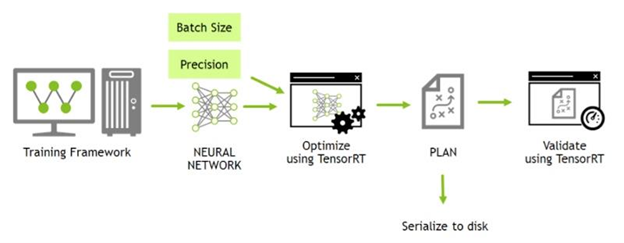

This image shows TensorRT pipeline. We already trained our model so let's move to model optimization.
We'll use TensorFlow-TensorRT (TF-TRT) - a deep-learning compiler for TensorFlow that optimizes TF models for inference on NVIDIA devices. TF-TRT is the TensorFlow integration for NVIDIA’s TensorRT (TRT) High-Performance Deep-Learning Inference SDK, allowing users to take advantage of its functionality directly within the TensorFlow framework. TensorRT performs several important transformations and optimizations to the neural network graph, including constant folding, pruning unnecessary graph nodes, layer fusion, and more.

Use `trt.TrtGraphConverterV2()` to convert saved CNN to TensorRT.
First let's keep the model precision of FP32. This funcion uses just two imputs:
- `input_saved_model_dir` (with path to saved TensorFlow model),
- `precision_mode` (this time we'll pass `trt.TrtPrecisionMode.FP32`).

In this way create `converter_fp32` instance. Next, convert the model using  `converter.convert()`.

Finally, we have to build our inference model engine with `converter.build()`. This function takes `input_fn` as input, so we have to define it. We'll create input generator. For optimization purposes the infernce engine needs to know the maximum batch size. Inside the function:
- select one `MAX_BATCH_SIZE` images from `test_images`,
- convert them to float32 (`.astype(np.float32)`),
- convert them to Tensor (`tf.constant()`).

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

# Instantiate the TF-TRT converter
converter32 = trt.TrtGraphConverterV2(...)

In [ ]:
MAX_BATCH_SIZE=32

# Implement function
def input_fn():
   x = ...
   yield [x]

... # Convert
... # Print summary
... # Build

Finally, save created model with `converter.save` to `./fp32_model`.

In [ ]:
... #Save

The easiest way of simplifying the model with TensorRT is using half-precision computing. Create new converter and perform the same steps for FP16 precision - save new model to `./fp16_model`.

In [ ]:
... # Instantiate the TF-TRT converter
... # Convert
... # Print summary
... # Build
... # Save

TensorRT can be used for quantization. Create another converter (precision `INT8`). For quantization however, we're going to need calibration dataset! Set `use_calibration` to `True` in `trt.TrtGraphConverterV2`.

Moreover, the `converter.convert()` function now uses `calibration_input_fn` as input. Implement `calibration_input_fn` where you loop through `test_images` selecting one `BATCH_SIZE` for `NUM_ITER` iterations. Remember to convert the images to float32 and Tensors.

Build the inference engine and save it to `./int8_model`.

In [ ]:
# Use data from the test/validation set to perform INT8 calibration
BATCH_SIZE=32
NUM_ITER=10
SAVED_MODEL_DIR="saved_model"
def calibration_input_fn():
   for i in range(NUM_ITER):
       x = ... #TODO
       yield [x]

... # Instantiate the TF-TRT converter
... # Convert
... # Print summary
... # Build
... # Save

Finally, let's evaluate all of the optimized networks. For this purpose create `benchmark_trt` function based on `benchmark` function. We're going to evaluate throughput and accuracy for FP32, FP16 and INT8 models. In this fuction, however, we're not going to use `predict` method. Instead, for each model, we'll load it from file and create its `inference_engine` object with this code:

In [ ]:
from tensorflow.python.saved_model import tag_constants

saved_model_loaded = tf.saved_model.load("PATH", tags=[tag_constants.SERVING])
infer = saved_model_loaded.signatures['serving_default']

We'll calculate model predictions with `preds = infer(x)`. Remeber, that `x` should be a float32 converted to Tensor. The resulting `preds` is TensorFlow directory, so before applying `argmax` we need to get the probability vector (with `preds['activation']`). Inside the function this operation should be timed and correct predictions should be calculated.

Benchmark each model and compare results.
After this task, we're ready to work with NVIDIA Jetson eGPUs!

In [ ]:
N_warmup_run = 50
N_run = 9000

def benchmark_trt(model, images, labels):

  for i in range(N_warmup_run):
    #ToDo, prepare image, inference

  for i in range(N_run):
    #ToDo, prepare image, time the inference, calculate accuracy

  print('Throughput: ') #TODO
  print('TOP1 accuacy: ') #TODO

benchmark_trt(...)
benchmark_trt(...)
benchmark_trt(...)

# CNN inference with NVIDIA Jetson embedded GPU

In [ ]:
!pip install tensorflow-datasets
import tensorflow_datasets as tfds

For benchmarking the NVIDIA Jetson Nano board, we are going to try a bit bigger model and harder dataset. We'll try running Imagenet classification with ResNet network.

More about the dataset: https://www.image-net.org/

More about the network: https://keras.io/api/applications/resnet/

It would take some time to train this model, so we'll just use ready, pretrained neural network. Use `tf.keras.applications.ResNet50()` function to create `CNN` instance (just study the link above). Use `include_top=True`, `weights="imagenet"` and `classes=1000`. Based on documentation answer the question - what is model's input size and what is it's output size?

In [ ]:
CNN_Jetson = ...

*Now*, let's download the dataset with `tfds` module. Use `tfds.load()` function with `imagenet_v2` dataset name (this is the dataset used for MobileNet training), `split='test[70%:]` (we need just 3000 samples), and `shuffle_files=True` and `as_supervised=True` parameters.

In [ ]:
ds = ...

Perfect. Now, we have both pretrained model and test dataset ready. We can benchmark the model. Implement benchmarking similarly as in previous lab, but:
- calulate not only throughput, and TOP1 accuracy, but also TOP5 accuracy (is correct label found in 5 classes with highest prediction probability?). The `((-preds[0]).argsort()[:5])` function may prove useful here.
- you can loop through dataset with `for image, label in tfds.as_numpy(ds):`
- each image should be resized to model input size and then reshaped to `(1,input_size, input_size, nr_of_channels)` before `predict` function. Just before model's input use preprocess_input()

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions

# Benchmarking throughput and TOP1/TOP5 accuracy
import time
import numpy as np
import cv2

N_warmup_run = 50
N_run = 500

for image, label in tfds.as_numpy(ds):
  # TODO


print( ... ) # Throughput
print( ... ) # TOP1 accuracy
print( ... ) # TOP1 accuracy

So we now how good does the ResNet50 performes for ImageNet dataset with host PCs (or Colab's GPU)! We can compare the achived scores for embedded GPU evaluation board! So now - ask your teacher for Jetson Nano board.

**Prepare Jetson Nano**
- First, take Jetson Nano board, connect it to power source, internet, monitor, mouse and keyboard.
- Log in to Jetson and finish OS instalation (some of the boards were not used yet).
- Open terminal and add cuda to PATH `export PATH=$PATH:/usr/local/cuda-10/bin`. Verify CUDA with `nvcc --version`.
- Connect USB camera to Jetson board.

Well, we have our Jetson Nano ready to go! We could load our Resnet50 model with Keras, convert and build it with TensorRT and run inference (remember, that `converter.build()` should always be run on final device, so the model would be optimazed for particular hardware).

However, this eGPU board however has only 2GB RAM (shared between CPU and GPU). This would take some time (it's possible, especially with more advanced Jetson boards).

Today, to save some time, we'll use NVIDIA Jetson Inference tools for testing! We'll compare how does this little eGPU with limited memory does in comparison with our CPU-based benchmark.

**Run camera DEMO**
- clone https://github.com/dusty-nv/jetson-inference repository on Jetson
- download the submodules with `git submodule update --init`
- run Jetson-inference docker with `./docker/run.sh`
- inside the docker, we should be able to test inference for supported models (ResNet50 is supported) - change directory to `./build/aarch64/bin/`
- run `./imagenet-camera.py --help` and study the arguments. We want to perform the inference for ResNet50 model, with TOP5 prediction displayed for our USB camera (it's source should be visible with `ls /dev/video*`)
- run `./imagenet-camera.py` with correct parameters. Study the outputs. What is the model precision in converted TensorRT model? Why? What is FPS for this demo?
- try to direct camera at some objects that can be correctly classified with ImageNet-pretrained network

<!-- **Extention exercise**

Compare JetsonNano performance with your GPU (or Colab's GPU). Enable GPU in Colab (or locally), use TensorRT to convert CNN to FP16, build the engine and benchmark the model. What is the difference in TOP1 and TOP5 accuracy after TensorRT optimization? What is the throughput for local GPU? -->